# BLAH7 - OGER - Subtask-3

Experiments on the impact of OGER annotations for document classification with very small datasets

# General code

In [1]:
%load_ext autoreload
%autoreload 2

In [54]:
from os import path
import numpy as np
import pandas as pd
from collections import Counter
from typing import Any, Dict, List, Callable, Optional, Tuple, Union
import seaborn as sns
import itertools
import copy

import joblib
import pickle
import dill # pickle variant , handle lambda functs
import cloudpickle

In [105]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.utils.multiclass import unique_labels
from sklearn import metrics as sk_metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#from sklearn.linear_model import LogisticRegression
from sklearn import svm

from tqdm import tqdm

## Misc

In [93]:
def train_pipeline(strategy, df_train, cls_field, display=True):
    strategy.fit(df_train, df_train[cls_field])
    return strategy
    
def evaluate_pipeline(strategy, df_train, df_test, cls_field, display=True, force_fit=False):    
            
    y_true = list(df_test[cls_field])
    
    y_pred = None
    if force_fit:
        strategy = train_pipeline(strategy, df_train, cls_field, display)
    try:
        y_pred = strategy.predict(df_test)
    except NotFittedError as e:
        strategy = train_pipeline(strategy, df_train, cls_field, display)
        y_pred = strategy.predict(df_test)
    
    
    if display:
        rpt = classification_report(y_true, y_pred, labels=list(set(y_true)), digits=4)
        print(rpt)
        #display(calculate_classification_metrics(y_pred, y_true))
        my_plot_confusionmatrix(true_labels = y_true, predicted_labels = y_pred)
    else:
        rpt = classification_report(y_true, y_pred, labels=list(set(y_true)), digits=4, output_dict=True)    

        return rpt['macro avg']['f1-score'], rpt['weighted avg']['f1-score'], rpt['accuracy'], {'y_true': y_true, 'y_pred': y_pred}

In [130]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

def my_plot_confusionmatrix(true_labels, predicted_labels):
        
    categs =  list(set(true_labels))
    
    make_confusion_matrix(
        confusion_matrix(true_labels, 
                         predicted_labels, 
                         labels=categs), 
                          categories = categs,
                          figsize=(12,10), cbar=False)

In [129]:
def split_train_val_test(df, test=0.25, val=0.0, stratisfy_field=None, random_state=42, display=True):
    
    train = int((1.0-val-test) *df.shape[0])
    test = int(test*df.shape[0])
    val = int(val*df.shape[0])
    
    #val = val/train # adjust for subsampling
    X_train_, X_test = train_test_split(
        df,
        test_size=test,
        random_state=random_state,
        stratify=df[stratisfy_field].values if not stratisfy_field is None else None,
    )

    if val > 0.0:
        X_train, X_val = train_test_split(
            X_train_,
            test_size=val,
            random_state=random_state,
            stratify=X_train_[stratisfy_field].values if not stratisfy_field is None else None,
        )       
    
        if display:
            print(f"Train:{X_train.shape[0]:,} ({(X_train.shape[0]/df.shape[0])*100:.2f}%), Val:{X_val.shape[0]:,} ({(X_val.shape[0]/df.shape[0])*100:.2f}%), Test:{X_test.shape[0]:,} ({(X_test.shape[0]/df.shape[0])*100:.2f}%)")
    
        rs = X_train, X_val, X_test
    else:
        X_train = X_train_
        if display:
            print(f"Train:{X_train.shape[0]:,} ({(X_train.shape[0]/df.shape[0])*100:.2f}%), Test:{X_test.shape[0]:,} ({(X_test.shape[0]/df.shape[0])*100:.2f}%)")
        rs = X_train, X_test


    if display:
        for ss in rs:
            print("-----------")
            print(report_cls_distribution(ss, stratisfy_field))

    return rs

## Bert as Sklearn transformer

In [3]:
# DL
import torch
import transformers
from transformers import BertModel, BertTokenizer

In [88]:
class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        bert_tokenizer,
        bert_model,
        max_length: int = 60,
        embedding_func: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
    ):
        self.tokenizer = bert_tokenizer
        self.model = bert_model
        self.model.eval()
        self.max_length = max_length
        self.embedding_func = embedding_func

        if self.embedding_func is None:
            self.embedding_func = lambda x: x[0][:, 0, :].squeeze() # Grab only the embedding for the [CLS] token
            #self.embedding_func = lambda x: torch.flatten(x[0]) # flatten embedding -> concatenates all embeddings for all the tokens



    def _tokenize(self, text: str) -> Tuple[torch.Tensor, torch.Tensor]:
        # Tokenize the text with the provided tokenizer
        tokenized_text = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_length,truncation=True
        )["input_ids"]
        
        # padding
        padded_text = tokenized_text + [0]*(self.max_length-len(tokenized_text))

        attention_mask = [1] * len(tokenized_text)
        # Create an attention mask telling BERT to use all words and ignore padded values
        #attention_mask = np.where(np.array(padded_text) != 0, 1, 0)

        # bert takes in a batch so we need to unsqueeze the rows
        return (
            #torch.tensor(padded_text).unsqueeze(0),
            torch.tensor(tokenized_text).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, text: str) -> torch.Tensor:
        tokenized, attention_mask = self._tokenize(text)

        embeddings = self.model(tokenized, attention_mask)
        return self.embedding_func(embeddings)

    def transform(self, text: List[str]):
        if isinstance(text, pd.Series):
            text = text.tolist()

        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(string) for string in text])

    def fit(self, X, y=None):
        """No fitting necessary so we just return ourselves"""
        return self

# Data

In [7]:
source_data_folder = './repoclinico'
destination_folder = './repoclinico/out'

In [8]:
df = pd.read_pickle(path.join(destination_folder, 'df_merged.xz'))

In [9]:
df.head()

,title,cls_speciality,cls_type,cls_topic,cls_subtopic,abstract,txt_file,full_text,type,preferred_form,entity_id,origin
0,Plausibility of therapeutic effects of Rho kin...,NaN,NaN,4,5.0,NaN,Abedi2020-Plausibility_of_therapeutic_effects_...,Since January 2020 Elsevier has created a COVI...,disease organism disease disease disease disea...,COVID-19 Coronavirus COVID-19 COVID-19 COVID-1...,C000657245 D017934 C000657245 C000657245 C0006...,MeSH supp (Diseases) MeSH desc (Organisms) MeS...
1,Heart Failure Collaboratory Statement on Clini...,12,3.0,NaN,NaN,NaN,Abraham2020-Heart_Failure_Collaboratory_Statem...,Since January 2020 Elsevier has created a COVI...,disease organism disease disease disease disea...,COVID-19 Coronavirus COVID-19 COVID-19 COVID-1...,C000657245 D017934 C000657245 C000657245 C0006...,MeSH supp (Diseases) MeSH desc (Organisms) MeS...
2,Gastrointestinal and Liver Manifestations of C...,17,7.0,NaN,NaN,"The worldwide pandemic of COVID-19, caused by ...",Agarwal2020-Gastrointestinal_and_Liver_Manifes...,Since January 2020 Elsevier has created a COVI...,disease organism disease disease disease disea...,COVID-19 Coronavirus COVID-19 COVID-19 COVID-1...,C000657245 D017934 C000657245 C000657245 C0006...,MeSH supp (Diseases) MeSH desc (Organisms) MeS...
3,COVID-19: Zoonotic aspects,NaN,NaN,26,NaN,NaN,Ahmad2020-COVID-19-Zoonotic_aspects.txt,Since January 2020 Elsevier has created a COVI...,disease organism disease disease disease disea...,COVID-19 Coronavirus COVID-19 COVID-19 COVID-1...,C000657245 D017934 C000657245 C000657245 C0006...,MeSH supp (Diseases) MeSH desc (Organisms) MeS...
4,COVID-19 and medical education,NaN,NaN,45,NaN,NaN,Ahmed2020-COVID-19_and_medical_education.txt,Since January 2020 Elsevier has created a COVI...,disease organism disease disease disease disea...,COVID-19 Coronavirus COVID-19 COVID-19 COVID-1...,C000657245 D017934 C000657245 C000657245 C0006...,MeSH supp (Diseases) MeSH desc (Organisms) MeS...


## build the dataframe (if not pickle available)

In [142]:

df = pd.read_csv(source_data_folder + "/blah7_subtask3.tsv", sep='\t')

In [143]:
df

,title,cls_speciality,cls_type,cls_topic,cls_subtopic,abstract,txt_file
0,Plausibility of therapeutic effects of Rho kin...,NaN,NaN,4,5.0,NaN,Abedi2020-Plausibility_of_therapeutic_effects_...
1,Heart Failure Collaboratory Statement on Clini...,12,3.0,NaN,NaN,NaN,Abraham2020-Heart_Failure_Collaboratory_Statem...
2,Gastrointestinal and Liver Manifestations of C...,17,7.0,NaN,NaN,"The worldwide pandemic of COVID-19, caused by ...",Agarwal2020-Gastrointestinal_and_Liver_Manifes...
3,COVID-19: Zoonotic aspects,NaN,NaN,26,NaN,NaN,Ahmad2020-COVID-19-Zoonotic_aspects.txt
4,COVID-19 and medical education,NaN,NaN,45,NaN,NaN,Ahmed2020-COVID-19_and_medical_education.txt
...,...,...,...,...,...,...,...
641,The cytokine release syndrome (CRS) of severe ...,NaN,NaN,28,NaN,"Since December 2019, a viral pneumonia (COVID-...",Zhang2020-The_cytokine_release_syndrome_CRS_of...
642,A comparative study on the clinical features o...,25,2.0,NaN,NaN,Background A novel coronavirus (2019-nCoV) has...,Zhao2020-A_comparative_study_on_the_clinical_f...
643,Obesity as a risk factor for greater severity ...,17,2.0,NaN,NaN,Background & Aims. Coronavirus disease 2019 (C...,Zheng2020-Obesity_as_a_risk_factor_for_greater...
644,Diabetes patients with COVID-19 need better care,15,2.0,NaN,NaN,NaN,Zhou2020-Diabetes_patients_with_COVID-19_need_...


In [144]:
def append_full_text(df, src_txt_path='./repoclinico/txt_files'):
    txts = ['']*len(df)
    for i, d in df.iterrows():        
        with open(path.join(src_txt_path, d.txt_file)) as f:
            lines = [l for l in f.read().splitlines() if l.strip()]
            txts[i] = ' '.join(lines)
            #print(lines)
    df['full_text'] = txts
    return df

df = append_full_text(df)

In [145]:
df.head()

,title,cls_speciality,cls_type,cls_topic,cls_subtopic,abstract,txt_file,full_text
0,Plausibility of therapeutic effects of Rho kin...,NaN,NaN,4,5.0,NaN,Abedi2020-Plausibility_of_therapeutic_effects_...,Since January 2020 Elsevier has created a COVI...
1,Heart Failure Collaboratory Statement on Clini...,12,3.0,NaN,NaN,NaN,Abraham2020-Heart_Failure_Collaboratory_Statem...,Since January 2020 Elsevier has created a COVI...
2,Gastrointestinal and Liver Manifestations of C...,17,7.0,NaN,NaN,"The worldwide pandemic of COVID-19, caused by ...",Agarwal2020-Gastrointestinal_and_Liver_Manifes...,Since January 2020 Elsevier has created a COVI...
3,COVID-19: Zoonotic aspects,NaN,NaN,26,NaN,NaN,Ahmad2020-COVID-19-Zoonotic_aspects.txt,Since January 2020 Elsevier has created a COVI...
4,COVID-19 and medical education,NaN,NaN,45,NaN,NaN,Ahmed2020-COVID-19_and_medical_education.txt,Since January 2020 Elsevier has created a COVI...


In [156]:
def append_oger_ner(df, src_oger_path='./repoclinico/oger_tsv'):
    fields=['TYPE', 'PREFERRED FORM', 'ENTITY ID', 'ORIGIN']
    series = {k.replace(' ', '_').lower(): ['']*len(df) for k in fields}    
    
    for i, d in df.iterrows():
        tmp = pd.read_csv(path.join(src_oger_path, d.txt_file.replace('.txt', '.oger.tsv')), sep='\t' )
        for f in fields:
            if f in tmp:
                series[f.replace(' ', '_').lower()][i] = ( ' '.join(list(tmp[f])) )
            #series[f.replace(' ', '_')][i] = f    
    
    for k in series:
        df[k] = series[k]
        
    return df

df = append_oger_ner(df, src_oger_path='./repoclinico/oger_tsv')
df.head()

,title,cls_speciality,cls_type,cls_topic,cls_subtopic,abstract,txt_file,full_text,type,preferred_form,entity_id,origin
0,Plausibility of therapeutic effects of Rho kin...,NaN,NaN,4,5.0,NaN,Abedi2020-Plausibility_of_therapeutic_effects_...,Since January 2020 Elsevier has created a COVI...,disease organism disease disease disease disea...,COVID-19 Coronavirus COVID-19 COVID-19 COVID-1...,C000657245 D017934 C000657245 C000657245 C0006...,MeSH supp (Diseases) MeSH desc (Organisms) MeS...
1,Heart Failure Collaboratory Statement on Clini...,12,3.0,NaN,NaN,NaN,Abraham2020-Heart_Failure_Collaboratory_Statem...,Since January 2020 Elsevier has created a COVI...,disease organism disease disease disease disea...,COVID-19 Coronavirus COVID-19 COVID-19 COVID-1...,C000657245 D017934 C000657245 C000657245 C0006...,MeSH supp (Diseases) MeSH desc (Organisms) MeS...
2,Gastrointestinal and Liver Manifestations of C...,17,7.0,NaN,NaN,"The worldwide pandemic of COVID-19, caused by ...",Agarwal2020-Gastrointestinal_and_Liver_Manifes...,Since January 2020 Elsevier has created a COVI...,disease organism disease disease disease disea...,COVID-19 Coronavirus COVID-19 COVID-19 COVID-1...,C000657245 D017934 C000657245 C000657245 C0006...,MeSH supp (Diseases) MeSH desc (Organisms) MeS...
3,COVID-19: Zoonotic aspects,NaN,NaN,26,NaN,NaN,Ahmad2020-COVID-19-Zoonotic_aspects.txt,Since January 2020 Elsevier has created a COVI...,disease organism disease disease disease disea...,COVID-19 Coronavirus COVID-19 COVID-19 COVID-1...,C000657245 D017934 C000657245 C000657245 C0006...,MeSH supp (Diseases) MeSH desc (Organisms) MeS...
4,COVID-19 and medical education,NaN,NaN,45,NaN,NaN,Ahmed2020-COVID-19_and_medical_education.txt,Since January 2020 Elsevier has created a COVI...,disease organism disease disease disease disea...,COVID-19 Coronavirus COVID-19 COVID-19 COVID-1...,C000657245 D017934 C000657245 C000657245 C0006...,MeSH supp (Diseases) MeSH desc (Organisms) MeS...


In [157]:
#df.to_pickle(path.join(destination_folder, 'df_merged.pkl'))
df.to_pickle(path.join(destination_folder, 'df_merged.xz'))

In [138]:
list(tmp_df[:1].PREFERRED_FORM)

['COVID-19 Coronavirus COVID-19 COVID-19 COVID-19 COVID-19 COVID-19 coenzyme M levothyroxine sodium anhydrous Therapeutic Uses Therapeutic Uses rhodopsin (rat) transcription termination factor Rho (Bacillus subtilis subsp. subtilis str. 168) transcription termination factor Rho (Escherichia coli K-12) rhodopsin (mouse) rhodopsin (cow) transcription termination factor Rho rhodopsin (chicken) rhodopsin protein rhomboid (fruit fly) Chloroacetanilide N-alkylformylase, oxygenase component rhodopsin (human) rhodopsin (zebrafish) RHO rho-Associated Kinases inhibitor Severe Acute Respiratory Syndrome Severe Acute Respiratory Syndrome severe acute respiratory syndrome coronavirus 2 COVID-19 Severe Acute Respiratory Syndrome Severe Acute Respiratory Syndrome severe acute respiratory syndrome coronavirus 2 serine--tRNA ligase, cytoplasmic (rat) HTH-type transcriptional regulator SarS (Staphylococcus aureus subsp. aureus NCTC 8325) serine--tRNA ligase, cytoplasmic (mouse) serine--tRNA ligase, cyto

In [28]:
def analyze_per_classification(df, field):
#df[df.abstract.notnull()]
    print(f"\n-------- {field} ---------")
    labels = Counter(df[field][df[field].notnull()])
    print(f"{len(labels)} with # examples --> {len(df[field][df[field].notnull()])}")
    print(labels)


analyze_per_classification(df, 'cls_speciality')
analyze_per_classification(df, 'cls_type')
analyze_per_classification(df, 'cls_topic')
analyze_per_classification(df, 'cls_subtopic')


-------- cls_speciality ---------
36 with # examples --> 269
Counter({'1': 41, '27': 23, '36': 22, '33': 18, '25': 17, '9': 15, '37': 14, '17': 11, '30': 11, '15': 8, '8': 7, '21': 7, '12': 6, '24': 6, '13': 6, '14': 5, '20': 5, '32': 5, '29': 5, '18': 4, '19': 4, '41': 4, '39': 3, '40': 3, '34': 3, '38': 2, '31': 2, '16': 2, '35': 2, '12,9': 2, '25,9': 1, '19,20': 1, '17,18': 1, '8,8,9': 1, '25,27': 1, '24,9': 1})

-------- cls_type ---------
6 with # examples --> 269
Counter({3.0: 163, 2.0: 54, 7.0: 31, 11.0: 10, 10.0: 9, 22.0: 2})

-------- cls_topic ---------
16 with # examples --> 383
Counter({'26': 105, '4': 76, '51': 56, '28': 43, '45': 29, '6': 23, '42': 23, '43': 15, '70': 3, '46': 3, '28,26': 2, '45,43': 1, '42,43': 1, '51,43': 1, '28,4': 1, '72': 1})

-------- cls_subtopic ---------
27 with # examples --> 161
Counter({3.0: 66, 55.0: 15, 52.0: 10, 63.0: 9, 47.0: 9, 23.0: 8, 64.0: 7, 69.0: 4, 71.0: 4, 5.0: 3, 48.0: 3, 66.0: 3, 62.0: 3, 54.0: 2, 61.0: 2, 57.0: 2, 50.0: 1, 68.0

# Experiments

## Classification AXIS => *cls_type*

In [10]:
cls_field = "cls_type"

In [89]:
df_train, df_test = split_train_val_test(df[df[cls_field].notnull()], test=0.2, val=0.0, stratisfy_field=cls_field)

Train:216 (80.30%), Test:53 (19.70%)
-----------
    cls  examples percentage
5  22.0         2       0.93
4  10.0         7       3.24
3  11.0         8       3.70
2   7.0        25      11.57
1   2.0        43      19.91
0   3.0       131      60.65
-----------
    cls  examples percentage
3  10.0         2       3.77
4  11.0         2       3.77
2   7.0         6      11.32
1   2.0        11      20.75
0   3.0        32      60.38


## Transformations & features

### Custom transformers

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.exceptions import NotFittedError

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC

tf_idf = Pipeline([ ("vect", CountVectorizer()), ("tfidf", TfidfTransformer()) ])
tfidf_vectorizer  = TfidfVectorizer()

In [131]:
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

    
class CategoricalImputer(BaseEstimator, TransformerMixin):
    '''Replace missing values in categorial fields with "Missing" '''
    def __init__(self, variables=None, replace_value='Missing'):
        #Check if the variables passed are in a list format, if not convert 
        #to list format and assign it to self.variables to be used in later 
        #methods
        self.replace_value=replace_value
        if not isinstance(variables,list):
            self.variables = [variables]
        else:
            self.variables = variables
    
    def fit(self, X:pd.DataFrame,y:pd.Series=None):
        #Nothing to do here, just return the dataframe as is
        return self
    
    def transform(self, X:pd.DataFrame):
        #Fill missing values and return the modified dataframe
        X=X.copy()
        for feature in self.variables:
            X[feature] = X[feature].fillna(self.replace_value)
        return X
    

In [132]:
#categoricalImputer = CategoricalImputer('cls_type', replace_value=0)
#categoricalImputer.transform(df)
#OneHotEncoder(handle_unknown='ignore').fit_transform(df.type)
# tfidf_vectorizer example
#tmp = tfidf_vectorizer.fit_transform(df.type)
#print(tfidf_vectorizer.vocabulary_)

### Features

In [56]:
feature_list=[

    # TF-IDF title
    ('title_tfidf', Pipeline([
        ('selector', ItemSelector(key='title')),
        ('tfidf', TfidfVectorizer(min_df=1)),
    ])),

    # TF-IDF type
    ('type_tfidf', Pipeline([
        ('selector', ItemSelector(key='type')),
        ('tfidf', TfidfVectorizer(min_df=1)),
    ])),

    # TF-IDF OGER_preferred-form
    ('pf_tfidf', Pipeline([
        ('selector', ItemSelector(key='preferred_form')),
        ('tfidf', TfidfVectorizer(min_df=1)),
    ])),

    # BOW (~LSA) OGER_preferred-form
    ('pf_bow', Pipeline([
        ('selector', ItemSelector(key='preferred_form')),
        ('tfidf', TfidfVectorizer()),
        ('best', TruncatedSVD(n_components=100)),
    ])),
    
    # TF-IDF OGER_entity-id
    ('entityid_tfidf', Pipeline([
        ('selector', ItemSelector(key='entity_id')),
        ('tfidf', TfidfVectorizer(min_df=1)),
    ])),            

    # TF-IDF OGER_origin
    ('origin_tfidf', Pipeline([
        ('selector', ItemSelector(key='origin')),
        ('tfidf', TfidfVectorizer(min_df=1)),
    ])),  

    # Pipeline for standard bag-of-words model for body
    ('text_bow', Pipeline([
        ('selector', ItemSelector(key='full_text')),
        ('tfidf', TfidfVectorizer()),
        ('best', TruncatedSVD(n_components=300)),
    ]))            
            
]

## Strategies

In [14]:
strategies = {}

In [15]:
strategies_rs = []

### Code

In [90]:
# Title(tfidf) + SVC
strategies['title(tfidf)::SVC'] = Pipeline([('union', FeatureUnion(
        transformer_list=[
            # TF-IDF title
            ('title_tfidf', Pipeline([
                ('selector', ItemSelector(key='title')),
                ('tfidf', tf_idf),
            ])),                    
        ],
    
    )),
    # Use a SVC classifier on the combined features
    ('svc', svm.LinearSVC(C=1.0, class_weight="balanced"))    
                                            
])

In [330]:
# Title + OGER-type + SVC
strategies['title(tfidf)_oger-type(tfidf)::SVC'] = Pipeline([('union', FeatureUnion(
        transformer_list=[

            # TF-IDF title
            ('title_tfidf', Pipeline([
                ('selector', ItemSelector(key='title')),
                ('tfidf', TfidfVectorizer(min_df=1)),
            ])),
            
            # TF-IDF type
            ('type_tfidf', Pipeline([
                ('selector', ItemSelector(key='type')),
                ('tfidf', TfidfVectorizer(min_df=1)),
            ]))
            
        ],  
    
    )),
    # Use a SVC classifier on the combined features
    #('svc', SVC(kernel='linear'))
    ('svc', svm.LinearSVC(C=1.0, class_weight="balanced"))    
                     
    ])

In [332]:
# Title(tfidf) + OGER-type(tfidf) + text(LSA) + SVC
strategies['title(tfidf)_oger-type(tfidf)_text(lsa)::SVC'] = Pipeline([('union', FeatureUnion(
        transformer_list=[

            # TF-IDF title
            ('title_tfidf', Pipeline([
                ('selector', ItemSelector(key='title')),
                ('tfidf', TfidfVectorizer(min_df=1)),
            ])),
            
            # TF-IDF type
            ('type_tfidf', Pipeline([
                ('selector', ItemSelector(key='type')),
                ('tfidf', TfidfVectorizer(min_df=1)),
            ])),

            # Pipeline for standard bag-of-words model for body
            ('text_bow', Pipeline([
                ('selector', ItemSelector(key='full_text')),
                ('tfidf', TfidfVectorizer()),
                ('best', TruncatedSVD(n_components=50)),
            ]))
            
        ],
    
        # weight components in FeatureUnion
        #transformer_weights={
        #    'title_tfidf': 0.8,
        #    'type_tfidf': 0.5,
        #    'text_bow': 1.0,
        #},    
    
    )),
    # Use a SVC classifier on the combined features
    #('svc', SVC(kernel='linear'))
    ('svc', svm.LinearSVC(C=1.0, class_weight="balanced"))    
                     
    ])

In [342]:
# Title(tfidf) + OGER-type(tfidf) + OGER-Preferred-Form(tfidf) + OGER-entity-id(tfidf) + SVC
strategies['title(tfidf)_oger-type(tfidf)_oger-pf(tfidf)_oger-entityid(tfidf)::SVC'] = Pipeline([('union', FeatureUnion(
        transformer_list=[

            # TF-IDF title
            ('title_tfidf', Pipeline([
                ('selector', ItemSelector(key='title')),
                ('tfidf', TfidfVectorizer(min_df=1)),
            ])),
            
            # TF-IDF type
            ('type_tfidf', Pipeline([
                ('selector', ItemSelector(key='type')),
                ('tfidf', TfidfVectorizer(min_df=1)),
            ])),

            # TF-IDF OGER_preferred-form
            ('pf_tfidf', Pipeline([
                ('selector', ItemSelector(key='preferred_form')),
                ('tfidf', TfidfVectorizer(min_df=1)),
            ])),
            
            # TF-IDF OGER_entity-id
            ('entityid_tfidf', Pipeline([
                ('selector', ItemSelector(key='entity_id')),
                ('tfidf', TfidfVectorizer(min_df=1)),
            ])),            
            
        ],
    
    
    )),
    # Use a SVC classifier on the combined features
    ('svc', svm.LinearSVC(C=1.0, class_weight="balanced"))    
                     
    ])

In [339]:
# Title(tfidf) + OGER-type(tfidf) + OGER-Preferred-Form(tfidf) + SVC
strategies['title(tfidf)_oger-type(tfidf)_oger-pf(tfidf)::SVC'] = Pipeline([('union', FeatureUnion(
        transformer_list=[

            # TF-IDF title
            ('title_tfidf', Pipeline([
                ('selector', ItemSelector(key='title')),
                ('tfidf', TfidfVectorizer(min_df=1)),
            ])),
            
            # TF-IDF type
            ('type_tfidf', Pipeline([
                ('selector', ItemSelector(key='type')),
                ('tfidf', TfidfVectorizer(min_df=1)),
            ])),

            # TF-IDF OGER_preferred-form
            ('pf_tfidf', Pipeline([
                ('selector', ItemSelector(key='preferred_form')),
                ('tfidf', TfidfVectorizer(min_df=1)),
            ])),
            
        ],
    
    
    )),
    # Use a SVC classifier on the combined features
    ('svc', svm.LinearSVC(C=1.0, class_weight="balanced"))    
                     
    ])

In [346]:
# Title(tfidf) + OGER-type(tfidf) + OGER-entity-id(tfidf) + SVC
strategies['title(tfidf)_oger-type(tfidf)_oger-entityid(tfidf)::SVC'] = Pipeline([('union', FeatureUnion(
        transformer_list=[

            # TF-IDF title
            ('title_tfidf', Pipeline([
                ('selector', ItemSelector(key='title')),
                ('tfidf', TfidfVectorizer(min_df=1)),
            ])),
            
            # TF-IDF type
            ('type_tfidf', Pipeline([
                ('selector', ItemSelector(key='type')),
                ('tfidf', TfidfVectorizer(min_df=1)),
            ])),
            
            # TF-IDF OGER_entity-id
            ('entityid_tfidf', Pipeline([
                ('selector', ItemSelector(key='entity_id')),
                ('tfidf', TfidfVectorizer(min_df=1)),
            ])),            
            
        ],
    
    
    )),
    # Use a SVC classifier on the combined features
    ('svc', svm.LinearSVC(C=1.0, class_weight="balanced"))    
                     
    ])

In [402]:
strategies['title(tfidf)_oger-entityid(tfidf)::SVC'] = Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('title_tfidf',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='title')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('entityid_tfidf',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='entity_id')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())]))])),
                ('svc', svm.LinearSVC(class_weight='balanced'))])


### Strategies evaluation

In [ ]:
%%time
for kname, strategy in strategies.items():
    if not kname in [s['strategy'] for s in strategies_rs]:
        print(f"==== Evaluating: {kname} ====")
        f1_macro, f1_micro, accuracy = evaluate_pipeline(strategy, df_train, df_test, cls_field, display=False)
        strategies_rs.append({'strategy': kname, 'f1-macro': f1_macro, 'f1-micro': f1_micro, 'accuracy': accuracy})
    
rs = pd.DataFrame(strategies_rs)
display(rs)

              precision    recall  f1-score   support

         2.0     0.7500    0.8182    0.7826        11
         3.0     0.7097    0.6875    0.6984        32
         7.0     0.1429    0.1667    0.1538         6
        10.0     1.0000    0.5000    0.6667         2
        11.0     0.0000    0.0000    0.0000         2

    accuracy                         0.6226        53
   macro avg     0.5205    0.4345    0.4603        53
weighted avg     0.6381    0.6226    0.6267        53



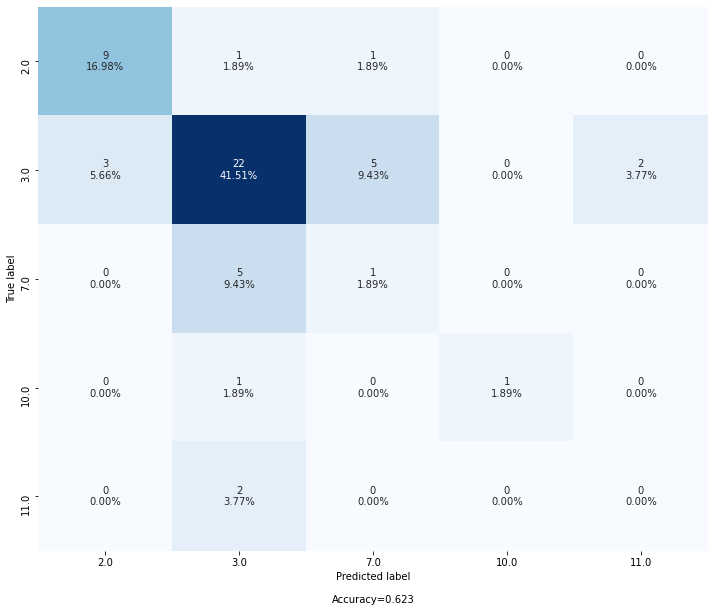

In [344]:
evaluate_pipeline(strategies['title(tfidf)::SVC'], df_train, df_test, cls_field, display=True)

              precision    recall  f1-score   support

         2.0     0.8182    0.8182    0.8182        11
         3.0     0.7419    0.7188    0.7302        32
         7.0     0.2500    0.3333    0.2857         6
        10.0     1.0000    0.5000    0.6667         2
        11.0     0.0000    0.0000    0.0000         2

    accuracy                         0.6604        53
   macro avg     0.5620    0.4741    0.5001        53
weighted avg     0.6838    0.6604    0.6682        53



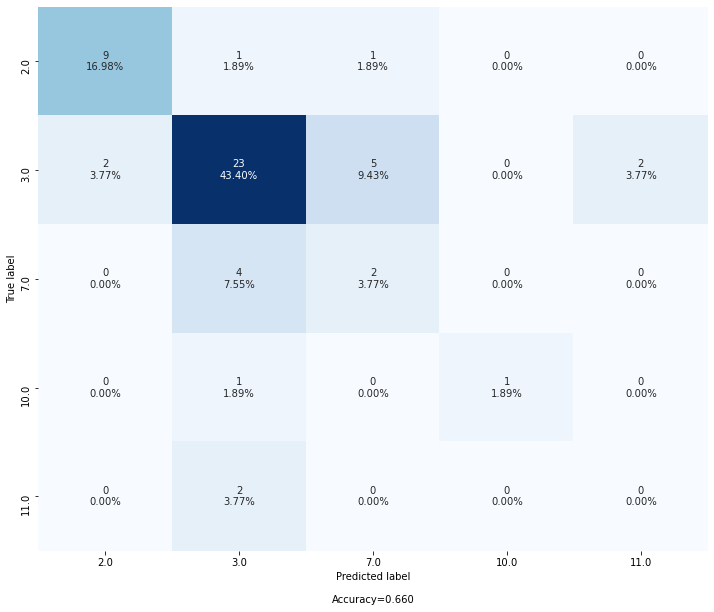

In [345]:
evaluate_pipeline(strategies['title(tfidf)_oger-type(tfidf)::SVC'], df_train, df_test, cls_field, display=True)

### Using BERT as transformer

In [89]:
bert_transformer = BertTransformer(BertTokenizer.from_pretrained('bert-base-uncased'), 
                                   BertModel.from_pretrained('bert-base-uncased'),
                                  embedding_func=lambda x: x[0][:, 0, :].squeeze())
classifier = svm.LinearSVC(C=1.0, class_weight="balanced")

In [38]:
%%time
model = Pipeline(
    [
        ("vectorizer", bert_transformer),
        ("classifier", classifier),
    ]
)
model.fit(x_train["content"], y_train)

/home/owlmx/miniconda3/envs/semeval2021/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/owlmx/miniconda3/envs/semeval2021/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Pipeline(steps=[('vectorizer',
                 BertTransformer(bert_model=None, bert_tokenizer=None,
                                 embedding_func=<function <lambda> at 0x7f90ea1d45f0>)),
                ('classifier', LinearSVC(class_weight='balanced'))])

# Exploration of best features combinations 

In [57]:
feature_combinations = list(itertools.chain.from_iterable([ list(itertools.combinations(feature_list, i+1)) for i in range(len(feature_list))]))
feature_combinations = [FeatureUnion(transformer_list=list(t)) for t in feature_combinations] 

print(f"Total number of feature combinations: {len(feature_combinations)}")

Total number of feature combinations: 127


In [58]:
full_pipeline = Pipeline([('features', FeatureUnion(
        transformer_list=[

            # TF-IDF title
            ('title_tfidf', Pipeline([
                ('selector', ItemSelector(key='title')),
                ('tfidf', TfidfVectorizer(min_df=1)),
            ])),
                        
        ],    
    
    )),
    # Use a SVC classifier on the combined features
    ('svc', svm.LinearSVC(C=1.0, class_weight="balanced"))    
                     
    ])

pg = [
    {
        'features': feature_combinations
    }
]

grid_search = GridSearchCV(full_pipeline, param_grid=pg, cv=3, n_jobs=3, scoring='f1_micro')

In [ ]:
# load saved search
grid_search = joblib.load(path.join(destination_folder, 'grid_search.joblib'))

In [59]:
%%time
df_tmp = pd.concat([df_train, df_test], ignore_index=True)
rs = grid_search.fit(df_tmp, list(df_tmp[cls_field])) # GS over all dataset (concat test and train set cause already filtered)
joblib.dump(grid_search, path.join(destination_folder, 'grid_search.joblib'))

/home/owlmx/miniconda3/envs/semeval2021/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


CPU times: user 15.4 s, sys: 4.52 s, total: 19.9 s
Wall time: 6min 40s


In [60]:
#grid_search.cv_results_
print("\nBest estimator found:")
print(grid_search.best_estimator_)

print("\nBest score:")
print(grid_search.best_score_)

print("\nBest parameters found:")
print(grid_search.best_params_)


Best estimator found:
Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('title_tfidf',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='title')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('origin_tfidf',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='origin')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('text_bow',
                                                 Pipeline(steps=[('selector',
       

### Re-Evaluate best estimator (train on training_ds and test on test_ds)

Without retraining (test data was already seen)

              precision    recall  f1-score   support

         2.0     1.0000    1.0000    1.0000        11
         3.0     1.0000    1.0000    1.0000        32
         7.0     1.0000    1.0000    1.0000         6
        10.0     1.0000    1.0000    1.0000         2
        11.0     1.0000    1.0000    1.0000         2

    accuracy                         1.0000        53
   macro avg     1.0000    1.0000    1.0000        53
weighted avg     1.0000    1.0000    1.0000        53



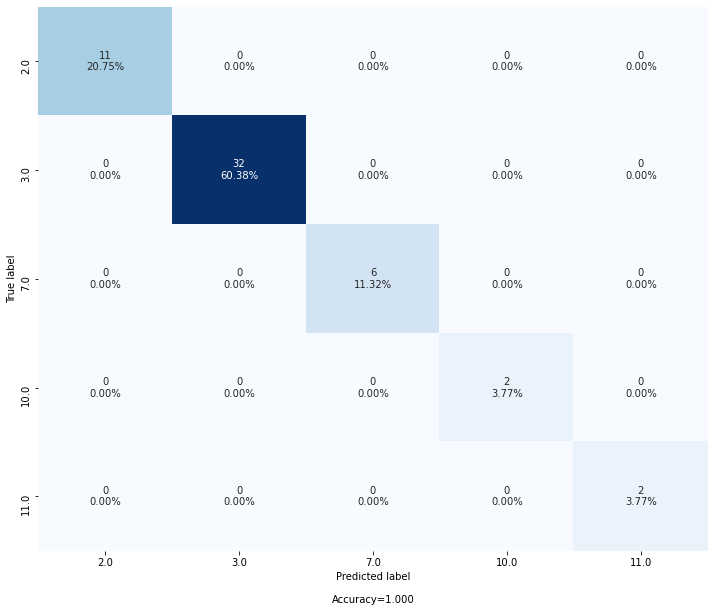

In [63]:
evaluate_pipeline(copy.deepcopy(grid_search.best_estimator_), df_train, df_test, cls_field, display=True, force_fit=False)

Retrain on train_data and apply on test_data... test data has not been seen

              precision    recall  f1-score   support

         2.0     0.7500    0.8182    0.7826        11
         3.0     0.7353    0.7812    0.7576        32
         7.0     0.2000    0.1667    0.1818         6
        10.0     1.0000    0.5000    0.6667         2
        11.0     0.0000    0.0000    0.0000         2

    accuracy                         0.6792        53
   macro avg     0.5371    0.4532    0.4777        53
weighted avg     0.6600    0.6792    0.6656        53



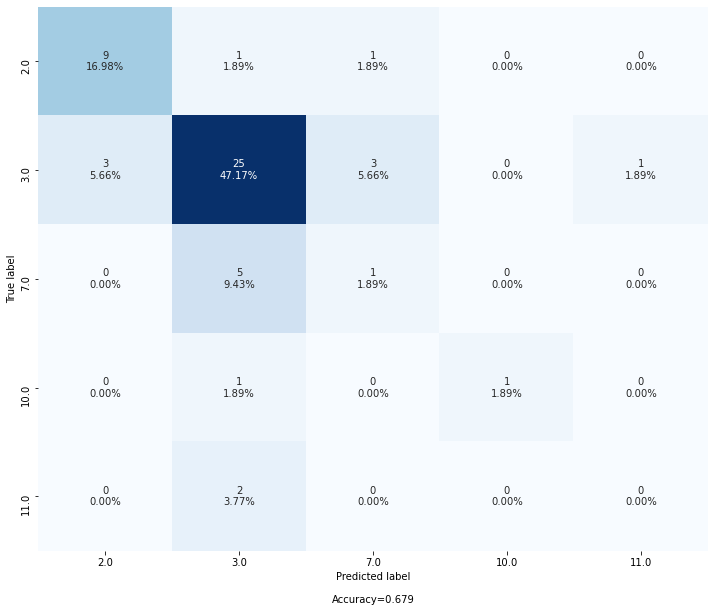

In [62]:
evaluate_pipeline(copy.deepcopy(grid_search.best_estimator_), df_train, df_test, cls_field, display=True, force_fit=True)

# Significance

In [101]:
models2compare = {'title_tfidf': strategies['title(tfidf)::SVC'], 'best_grid_search': grid_search.best_estimator_}

In [108]:
def evaluate_multiple_runs(df, models, n_runs=30, test_size=0.2, val_size=0.0, stratisfy_field=cls_field ):
    '''Run n times the models with random train and test samples from dataset'''
    rs = []
    rs_model = {}
    for i in tqdm(range(n_runs)):
        # resample (random)
        df_train_, df_test_ = split_train_val_test(df[df[cls_field].notnull()], test=0.2, val=0.0, stratisfy_field=cls_field, random_state=None, display=False)
        
        # for each model        
        for model_name, model in models.items():
            if not model_name in rs_model:
                rs_model[model_name] = []             
            
            # retrain and predict
            rs = evaluate_pipeline(copy.deepcopy(model), df_train_, df_test_, cls_field, display=False, force_fit=True)
            
            #evaluate
            #'mcc': metrics.matthews_corrcoef(y_true=rs[3]['y_true'], y_pred=rs[3]['y_pred'])
            rs_model[model_name].append( metrics.f1_score(y_true=rs[3]['y_true'], y_pred=rs[3]['y_pred'], average='weighted') )
            
    return pd.DataFrame(rs_model)

comparative_runs = evaluate_multiple_runs(df, models2compare, n_runs=30)

  3%|▎         | 1/30 [00:02<01:24,  2.93s/it]/home/owlmx/miniconda3/envs/semeval2021/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  7%|▋         | 2/30 [00:05<01:21,  2.90s/it]/home/owlmx/miniconda3/envs/semeval2021/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 17%|█▋        | 5/30 [00:14<01:11,  2.85s/it]/home/owlmx/miniconda3/envs/semeval2021/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being s

In [111]:
comparative_runs.to_csv(path.join(destination_folder, 'compartaive_runs.csv'))

In [110]:
comparative_runs

,title_tfidf,best_grid_search
0,0.641240,0.686792
1,0.576079,0.680351
2,0.620214,0.664570
3,0.598383,0.665469
4,0.650728,0.718085
5,0.669298,0.753418
6,0.755319,0.761426
7,0.675032,0.719792
8,0.694801,0.752735
9,0.714870,0.720586


In [124]:
from scipy.stats import normaltest, ttest_ind
from matplotlib import pyplot

       title_tfidf  best_grid_search
count    30.000000         30.000000
mean      0.669388          0.739631
std       0.044472          0.041833
min       0.576079          0.664570
25%       0.641477          0.719991
50%       0.672372          0.737765
75%       0.694262          0.756225
max       0.755319          0.820485


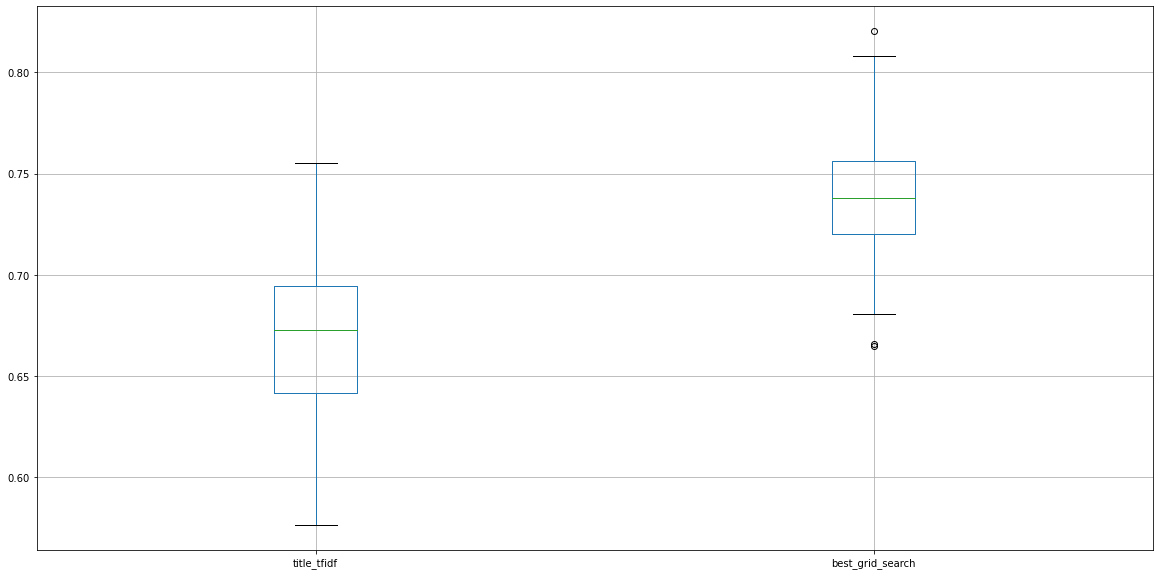

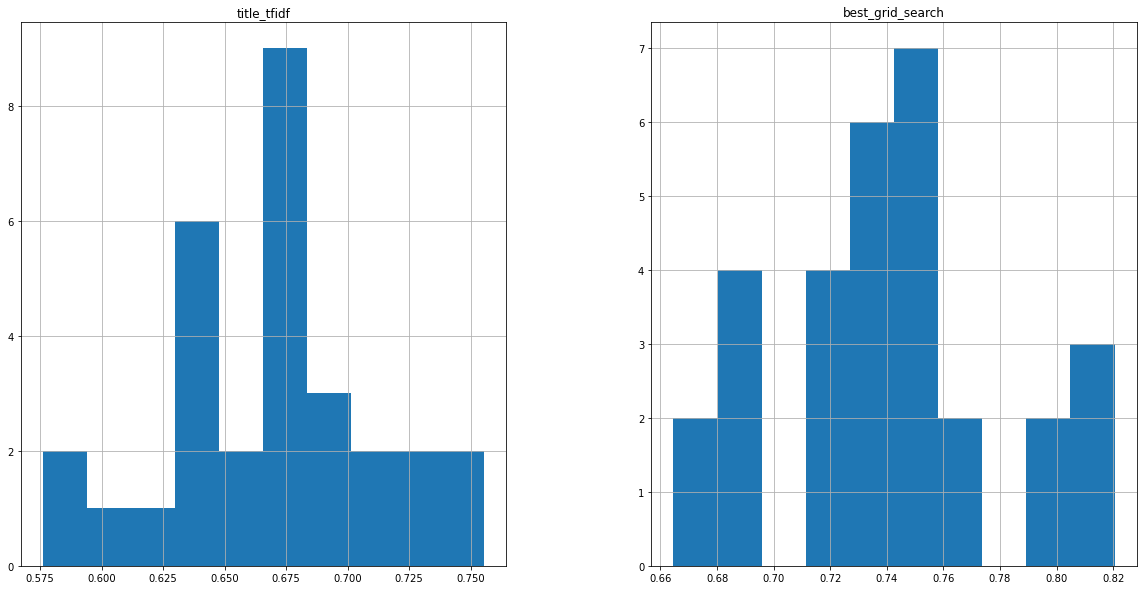

In [121]:
# descriptive stats
print(comparative_runs.describe())
# box and whisker plot
comparative_runs.boxplot()
pyplot.show()
# histogram
comparative_runs.hist()
pyplot.show()

In [122]:
for col in comparative_runs.columns:
    value, p = normaltest(list(comparative_runs[col]))
    print(value, p)
    if p >= 0.05:
        print(f"{col} ~ Normal\n")
    else:
        print(f"{col} ~ NOT Normal\n")

0.07551119977416455 0.9629482567971064
title_tfidf ~ Normal

0.13534810109478523 0.9345650449019005
best_grid_search ~ Normal



In [127]:
# calculate the significance
value, p = ttest_ind(comparative_runs[comparative_runs.columns[0]], 
                         comparative_runs[comparative_runs.columns[1]], equal_var=True)    

print(value, p)
if p > 0.05:
    print(f"~ Samples from the same distributions (fail to reject H0)")
else:
    print(f"~ Samples from different distributions (reject H0) => Statiscally significant")
    

-6.301521320873949 4.3166806064627776e-08
~ Samples from different distributions (reject H0) => Statiscally significant


<AxesSubplot:>

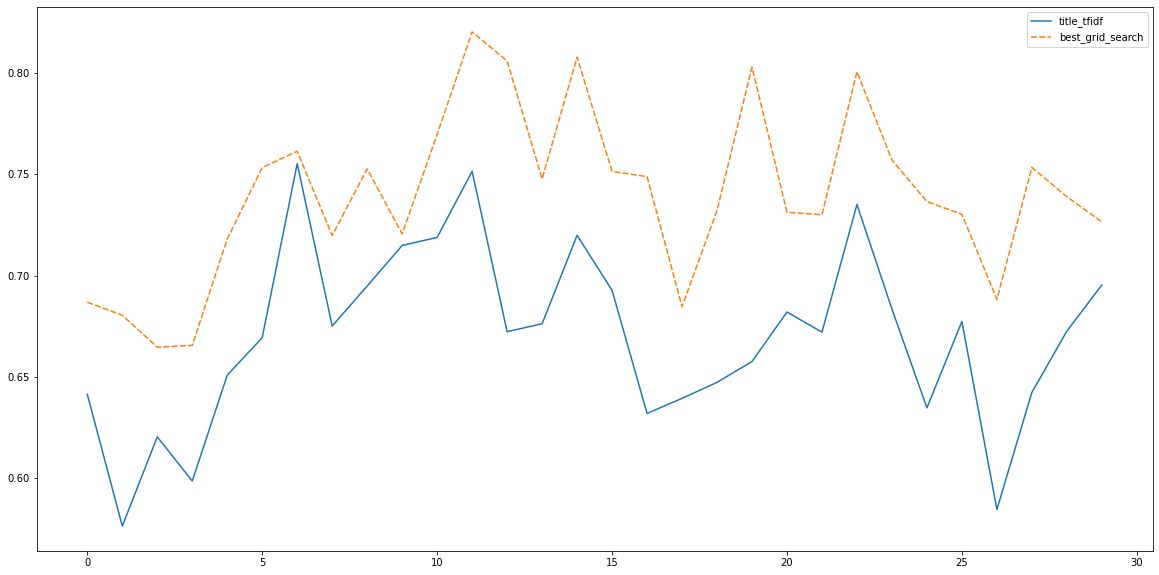

In [128]:
sns.lineplot(data=comparative_runs)